# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
traj = np.loadtxt(open("simulation/data/traj100k.txt", "rb"), delimiter=",")
trajPts = np.shape(traj)[0] #points per trajectory
numTraj = np.shape(traj)[1]//3 #number of total trajectories
#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
jointPos = np.loadtxt(open("simulation/data/jointPos100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [3]:
#reshape traj data into 3d numpy array
# print(np.shape(traj)) #(10,30) -> should be (10,3,10)
t = np.zeros([trajPts,3,numTraj])
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//3):
        t[j,:,i] = traj[j,3*i:3*(i+1)]
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 3, 100000)
(100000, 3, 10)
(100000, 10, 3)


In [4]:
#Convert data from numpy to tensors

#shuffle data

In [5]:
from network import Net

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

#TODO -> shuffle data


# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [6]:
model = Net() #starting out with basic linear feedforward network (CNN wrote for CIFR-10 does not work with 2D data)

runLen = 300    

def scheduler(epoch, lr):
    part1 = runLen//3
    part2 = 2*runLen//3
    
    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Train Model
trace = model.fit(x=x_train, y=y_train, batch_size=256, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 3)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 3)        12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 8, 16)        160         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8, 16)        784         conv1d[0][0]                     
_______________________________________________________________________________________

352/352 [==============================] - 3s 9ms/step - loss: 699.0064 - mean_squared_error: 699.0064 - val_loss: 675.3813 - val_mean_squared_error: 675.3813
Epoch 2/300
352/352 [==============================] - 3s 8ms/step - loss: 537.5065 - mean_squared_error: 537.5065 - val_loss: 496.7490 - val_mean_squared_error: 496.7490
Epoch 3/300
352/352 [==============================] - 3s 8ms/step - loss: 501.6385 - mean_squared_error: 501.6385 - val_loss: 591.4052 - val_mean_squared_error: 591.4052
Epoch 4/300
352/352 [==============================] - 3s 9ms/step - loss: 464.3881 - mean_squared_error: 464.3881 - val_loss: 490.9832 - val_mean_squared_error: 490.9832
Epoch 5/300
352/352 [==============================] - 3s 8ms/step - loss: 449.9445 - mean_squared_error: 449.9445 - val_loss: 604.8453 - val_mean_squared_error: 604.8453
Epoch 6/300
352/352 [==============================] - 3s 8ms/step - loss: 425.9848 - mean_squared_error: 425.9848 - val_loss: 427.4637 - val_mean_squared_er

Epoch 49/300
352/352 [==============================] - 3s 8ms/step - loss: 179.5131 - mean_squared_error: 179.5131 - val_loss: 238.8640 - val_mean_squared_error: 238.8640
Epoch 50/300
352/352 [==============================] - 3s 8ms/step - loss: 177.5769 - mean_squared_error: 177.5769 - val_loss: 230.4238 - val_mean_squared_error: 230.4238
Epoch 51/300
352/352 [==============================] - 3s 8ms/step - loss: 176.6440 - mean_squared_error: 176.6440 - val_loss: 228.3163 - val_mean_squared_error: 228.3163
Epoch 52/300
352/352 [==============================] - 3s 8ms/step - loss: 176.2540 - mean_squared_error: 176.2540 - val_loss: 223.2504 - val_mean_squared_error: 223.2504
Epoch 53/300
352/352 [==============================] - 3s 8ms/step - loss: 173.7872 - mean_squared_error: 173.7872 - val_loss: 222.2379 - val_mean_squared_error: 222.2379
Epoch 54/300
352/352 [==============================] - 3s 8ms/step - loss: 172.0649 - mean_squared_error: 172.0649 - val_loss: 231.0499 - v

352/352 [==============================] - 3s 8ms/step - loss: 134.0785 - mean_squared_error: 134.0785 - val_loss: 213.7306 - val_mean_squared_error: 213.7306
Epoch 97/300
352/352 [==============================] - 3s 8ms/step - loss: 134.5246 - mean_squared_error: 134.5246 - val_loss: 216.9158 - val_mean_squared_error: 216.9158
Epoch 98/300
352/352 [==============================] - 3s 9ms/step - loss: 134.7344 - mean_squared_error: 134.7344 - val_loss: 223.7167 - val_mean_squared_error: 223.7167
Epoch 99/300
352/352 [==============================] - 3s 8ms/step - loss: 131.8088 - mean_squared_error: 131.8088 - val_loss: 216.6779 - val_mean_squared_error: 216.6779
Epoch 100/300
352/352 [==============================] - 3s 9ms/step - loss: 133.5522 - mean_squared_error: 133.5522 - val_loss: 216.3427 - val_mean_squared_error: 216.3427
Epoch 101/300
352/352 [==============================] - 3s 9ms/step - loss: 112.2862 - mean_squared_error: 112.2862 - val_loss: 196.2647 - val_mean_squ

Epoch 144/300
352/352 [==============================] - 3s 8ms/step - loss: 94.7801 - mean_squared_error: 94.7801 - val_loss: 201.4345 - val_mean_squared_error: 201.4345
Epoch 145/300
352/352 [==============================] - 3s 8ms/step - loss: 94.5551 - mean_squared_error: 94.5551 - val_loss: 202.2141 - val_mean_squared_error: 202.2141
Epoch 146/300
352/352 [==============================] - 3s 8ms/step - loss: 94.5219 - mean_squared_error: 94.5219 - val_loss: 201.2598 - val_mean_squared_error: 201.2598
Epoch 147/300
352/352 [==============================] - 3s 8ms/step - loss: 94.6449 - mean_squared_error: 94.6449 - val_loss: 201.3008 - val_mean_squared_error: 201.3008
Epoch 148/300
352/352 [==============================] - 3s 9ms/step - loss: 94.3959 - mean_squared_error: 94.3959 - val_loss: 201.6476 - val_mean_squared_error: 201.6476
Epoch 149/300
352/352 [==============================] - 3s 9ms/step - loss: 94.6078 - mean_squared_error: 94.6078 - val_loss: 202.0258 - val_mea

Epoch 192/300
352/352 [==============================] - 3s 8ms/step - loss: 90.5410 - mean_squared_error: 90.5410 - val_loss: 204.9751 - val_mean_squared_error: 204.9751
Epoch 193/300
352/352 [==============================] - 3s 8ms/step - loss: 90.0093 - mean_squared_error: 90.0093 - val_loss: 206.0442 - val_mean_squared_error: 206.0442
Epoch 194/300
352/352 [==============================] - 3s 8ms/step - loss: 89.3390 - mean_squared_error: 89.3390 - val_loss: 206.0932 - val_mean_squared_error: 206.0932
Epoch 195/300
352/352 [==============================] - 3s 8ms/step - loss: 89.9259 - mean_squared_error: 89.9259 - val_loss: 206.3636 - val_mean_squared_error: 206.3636
Epoch 196/300
352/352 [==============================] - 3s 9ms/step - loss: 89.7158 - mean_squared_error: 89.7158 - val_loss: 205.5660 - val_mean_squared_error: 205.5660
Epoch 197/300
352/352 [==============================] - 3s 9ms/step - loss: 89.4356 - mean_squared_error: 89.4356 - val_loss: 206.0514 - val_mea

Epoch 240/300
352/352 [==============================] - 3s 9ms/step - loss: 85.6709 - mean_squared_error: 85.6709 - val_loss: 204.8596 - val_mean_squared_error: 204.8596
Epoch 241/300
352/352 [==============================] - 3s 9ms/step - loss: 85.6079 - mean_squared_error: 85.6079 - val_loss: 204.7959 - val_mean_squared_error: 204.7959
Epoch 242/300
352/352 [==============================] - 3s 9ms/step - loss: 85.8772 - mean_squared_error: 85.8772 - val_loss: 205.2480 - val_mean_squared_error: 205.2480
Epoch 243/300
352/352 [==============================] - 3s 8ms/step - loss: 85.9173 - mean_squared_error: 85.9173 - val_loss: 204.9974 - val_mean_squared_error: 204.9974
Epoch 244/300
352/352 [==============================] - 3s 8ms/step - loss: 86.1476 - mean_squared_error: 86.1476 - val_loss: 204.8669 - val_mean_squared_error: 204.8669
Epoch 245/300
352/352 [==============================] - 3s 8ms/step - loss: 86.1261 - mean_squared_error: 86.1261 - val_loss: 204.9241 - val_mea

Epoch 288/300
352/352 [==============================] - 3s 8ms/step - loss: 85.8905 - mean_squared_error: 85.8905 - val_loss: 205.3634 - val_mean_squared_error: 205.3634
Epoch 289/300
352/352 [==============================] - 3s 8ms/step - loss: 85.7432 - mean_squared_error: 85.7432 - val_loss: 205.4556 - val_mean_squared_error: 205.4556
Epoch 290/300
352/352 [==============================] - 3s 8ms/step - loss: 84.9090 - mean_squared_error: 84.9090 - val_loss: 205.5850 - val_mean_squared_error: 205.5850
Epoch 291/300
352/352 [==============================] - 3s 8ms/step - loss: 85.7239 - mean_squared_error: 85.7239 - val_loss: 205.5366 - val_mean_squared_error: 205.5366
Epoch 292/300
352/352 [==============================] - 3s 8ms/step - loss: 85.1761 - mean_squared_error: 85.1761 - val_loss: 205.5332 - val_mean_squared_error: 205.5332
Epoch 293/300
352/352 [==============================] - 3s 8ms/step - loss: 84.9508 - mean_squared_error: 84.9508 - val_loss: 205.5015 - val_mea

(10.0, 1000.0)

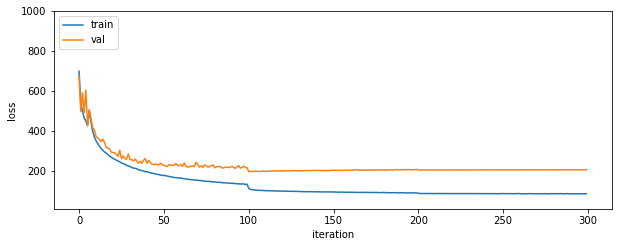

In [7]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(10,1000)

In [10]:
#test model
prediction = model.predict(x_train[-100:-1])
# print(prediction)
actual = y_train[-100:-1]
# print(actual)

error = (actual - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130] #TODO -> these are not correct
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*100)/100) #1 is full range of joint
print("total error = ",sum(rel_error))
#current best is: 0.566 @ [0.08 0.07 0.03 0.12 0.11 0.03 0.08]

print(prediction[10])
print(actual[10])

average error =  [ 4.2387877  4.729311   2.4435675 14.197172  13.927961  13.865121
 10.806598 ]
error as frac of joint range =  [0.08 0.07 0.03 0.12 0.11 0.03 0.08]
total error =  0.5665720485140393
[ -0.16843656   0.11421638   0.271204   -21.454273    12.484665
  14.405404   -13.966602  ]
tf.Tensor([  2.8005   4.6661   4.1648 -20.32     9.7146  24.804  -10.767 ], shape=(7,), dtype=float32)


In [11]:
model.save("trajectory_cls.kmod")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trajectory_cls.kmod\assets


In [17]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([99,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (actual - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

print(fake_avg/ranges)

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint

tf.Tensor([13.040113 16.174479 43.41501  35.256268 36.824196 72.12078  41.694756], shape=(7,), dtype=float32)
tf.Tensor(
[0.26080227 0.26957464 0.6431853  0.32051152 0.30686828 0.2003355
 0.3207289 ], shape=(7,), dtype=float32)
